# Background and Problem Description

Due to the excess number of students at the University of Mars and the lack of teaching assistants, it is necessary to impose a question limit of five on the number of questions given to each student on the mid-term exam. All questions must used must be taken from the test bank of approximately 400 pre-approved questions. Up to 50% of questions can be unused on the midterm. The goal of this data-driven study is to then find the questions that should be excluded from the exam generation algorithm to provide the most meaningful rank of students in the class. 

# Data Analysis

In [76]:
import numpy as np
import pandas as pd
import pystan
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt

data = pd.read_csv("astudentData.csv") #load the dataset
question_bank = data['question_id'].unique() #keep question bank for later

## Motivation
The data consists of 409,520 observations, 12839 students, and 391 questions. This means that at most 195 questions can be excluded from the test bank. Before I begin any data analysis, it is imperative to prepare the data for analysis. To begin, I check to see if there are any questions that no student has answered correctly or all students have answered correctly. If all students get a question wrong, it means that the question is too easy. Conversely, if all students get a question right, it means that the question is too hard. In either case, these questions will not create any variance in the midterm results. Thus, I can immediately eliminate these questions. 

In [36]:
#checking if any questions are too easy
group_questions = data.groupby(['question_id']).mean()
prop_correct = group_questions[['correct']].sort_values(by='correct')
prop_correct.head()

,correct
question_id,
12719,0.120000
15412,0.132931
12755,0.137405
12717,0.214286
5566,0.218750


In [37]:
#checking if any questions are too hard
prop_correct.tail()

,correct
question_id,
12168,0.913889
4539,0.916230
5515,0.922794
1591,0.935065
268,0.941176


From looking at the first table, we see that no questions were so hard that no student answered them correctly. However, from looking at the second table, we see that there was a question that everyone answered correctly, so we remove that question from our dataset. 

In [4]:
data = data.loc[data['question_id'] != 12665]

When thinking of a machine learning or stats method to use, my initial thought was to find the questions that have the highest variance in responses and to group questions that had high correlations in their responses (i.e., students who answered question A correctly also tended to answer question B correctly). I realized this approach would not work because a question that has high variance does not necessarily imply that it is a good question for creating a meaningful hierarchy of students (e.g., it could be a difficult question that everyone guesses on). Also I would also have to account for the difference in ability of each student. This led me to thinking about latent variable modeling where the latent variables would be the abilities of each student and the difficulty of each question which is how I came upon IRT models. In the two parameter Rasch model we model probability the student $j$ answers question $i$ correctly as 
$$\text{logit}\big(P(y_{ij}=1|\theta_j)\big) = \alpha_i(\theta_j - \beta_i),$$
where $\theta_j$ is the student's ability, $\beta_i$ is the difficulty of the question, and $\alpha_i$ is how well the question discriminates between weaker and stronger students.

Not every student answers every question in the dataset. This makes standard regression methods difficult, but a Bayesian approach would still work well in this scenario. I use pystan to fit a 2-parameter Rasch model on the data and then take posterior draws on the $\alpha_i$ parameters. Afterwards, I keep the 196 questions that have the largest mean posterior $\alpha$ values. These questions are the best in terms of distinguishing the students that understand the material and those that do not. Unfortunately, I cannot verify my analysis on the original data as I do not know the true parameter values. However, if I simulate data with known parameters and recover these parameters using this Bayesian rasch model approach, then I can be confident drawing inferences with the model on the real given data.

## Simulation Study

For the simulation, there will be 400 questions in the test bank and just 500 students. The number of questions a student answers is a random normal variable with mean 100 and standard deviation 10. This is to simulate how in the actual dataset, each student does not answer the same amount of questions. The discrimination parameters $\alpha_j$ are drawn from a log normal distribution with mean 0.5 and shape 1, the difficulty parameters $\beta_j$ are drawn from a normal distribution with mean 0 and standard deviation 5, and the student ability parameters $\theta_j$ are drawn from a standard normal distribution. The outcome variables (whether the student answered the question correctly or not) are random Bernoulli variables with the probability of success as the inverse logit of $\alpha_i(\theta_j - \beta_i)$ for each student-question pair. 

In [23]:
num_questions = 400
num_students = 500

#generate discrimination and difficulty parameters for 400 test questions
alphas = scipy.stats.lognorm.rvs(s=1, loc=0.5, size=num_questions)
betas = scipy.stats.norm.rvs(scale=5, size=num_questions) 

#generate ability parameter for 500 students
thetas = scipy.stats.norm().rvs(num_students) 

#pick questions that students answer; each students answers around 30 randomly
avg = 100 #average questions answered
sd = 10
questions_each_student = np.rint(scipy.stats.norm.rvs(loc=avg, scale=sd, size=num_students)).astype(int)
num_obs = np.sum(questions_each_student)

student_column = np.repeat(np.arange(1,np.size(questions_each_student)+1), questions_each_student)
question_column = np.empty(num_obs)
correct_column = np.empty(num_obs)

present_index = 0 #keep track of the index we are updating
for i in range(num_students):
    nq = questions_each_student[i] #number of questions for student i
    questions_answered = np.random.choice(num_questions, nq,  replace=False) #randomly selecting which questions each student answers
    question_column[present_index:present_index + nq] = questions_answered
    p = scipy.special.expit(alphas[questions_answered] * (thetas[i] - betas[questions_answered]))
    correct_column[present_index:present_index + nq] = scipy.stats.bernoulli.rvs(p)
    present_index = present_index + nq
    
question_column = (question_column + 1).astype(int) #pystan indexing starts at 1
correct_column = correct_column.astype(int)

After we simulate the data and format it correctly so pystan can handle it, we pass the data into the model we will use for the real data.

In [9]:
lrt_code = """
data {
  int<lower=1> I;               // # questions
  int<lower=1> J;               // # persons
  int<lower=1> N;               // # observations
  int<lower=1, upper=I> ii[N];  // question for n
  int<lower=1, upper=J> jj[N];  // person for n
  int<lower=0, upper=1> y[N];   // correctness for n
}
parameters {
  vector<lower=0>[I] alpha;     // discrimination for item i
  vector[I] beta;               // difficulty for item i
  vector[J] theta;              // ability for person j
}
model {
  vector[N] eta;
  alpha ~ lognormal(0.5,1);
  beta ~ normal(0,10);
  theta ~ normal(0,1);
  y ~ bernoulli_logit(alpha[ii] .* (theta[jj] - beta[ii]));
}
"""

After sampling from the posterior distribution, I check the posterior mean of the parameters. If the model has done a good job of recovering the parameters, a scatterplot of the posterior mean of the parameters against the actual parameter values should be centered around the identity line.

In [ ]:
sm = pystan.StanModel(model_code=lrt_code) #pystan model

#format data for pystan
test_data = {'I': num_questions, 
            'J': num_students,
            'N': num_obs,
            'ii': pd.Series(question_column),
            'jj': pd.Series(student_column),
            'y': pd.Series(correct_column)}

test_fit = sm.sampling(data=test_data, iter=1000, chains=4, sample_file='Test_Draws', n_jobs=4, 
                  control={'adapt_delta' : 0.875, 'max_treedepth' : 15})

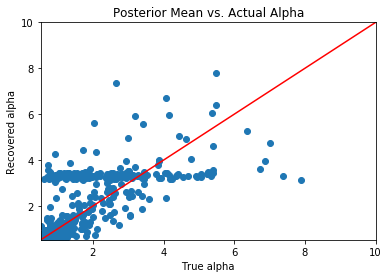

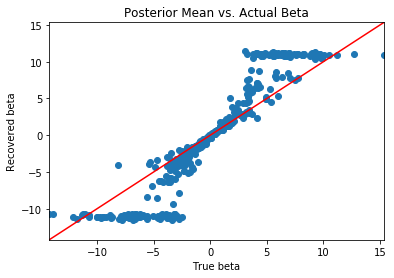

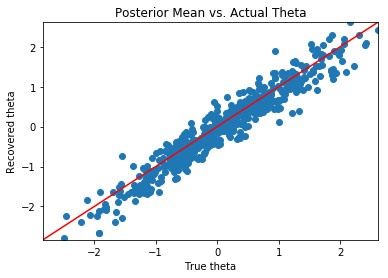

In [29]:
#Plot for alphas
lineStart = alphas.min() #need to draw identity line
lineEnd = alphas.max()
pred_alphas = test_fit.to_dataframe(pars='alpha') 

#index 9 is where the actual posterior parameter values appear in the dataframe
#and we want the mean of the posterior draws
mean_alphas = pred_alphas.mean()[9:].as_matrix() 
plt.figure()
plt.scatter(alphas, mean_alphas)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r') #drawing identity line
plt.xlim(lineStart, 10)
plt.ylim(lineStart, 10)
plt.xlabel("True alpha")
plt.ylabel("Recovered alpha")
plt.title("Posterior Mean vs. Actual Alpha")
plt.show()

#Plot for betas
lineStart = betas.min()
lineEnd = betas.max()
pred_betas = test_fit.to_dataframe(pars='beta')
mean_betas = pred_betas.mean()[9:].as_matrix()

plt.figure()
plt.scatter(betas, mean_betas)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel("True beta")
plt.ylabel("Recovered beta")
plt.title("Posterior Mean vs. Actual Beta")
plt.show()

#Plot for thetas
lineStart = thetas.min()
lineEnd = thetas.max()
pred_thetas = test_fit.to_dataframe(pars='theta')
mean_thetas = pred_thetas.mean()[9:].as_matrix()

plt.figure()
plt.scatter(thetas, mean_thetas)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel("True theta")
plt.ylabel("Recovered theta")
plt.title("Posterior Mean vs. Actual Theta")
plt.show()

The 3 scatterplots above indicate that while the Bayesian 2-parameter IRT model approach successfully recovered the student's abilities, $\theta,$ it fails to recover the $\beta$ and the $\alpha$ parameters. For the $\beta$ parameter, the posterior mean of the predicted $\beta$s is roughly equal to the true value when $\beta$ is between -5 and 5. For larger values of $\beta$, the posterior draws seem to be blown up. The scatterplot of the $\alpha$ parameters, the set of parameters we care most about, seem to roughly fall along the identity line except for an anomalous flat stretch of points where the posterior mean of the $\alpha$s is slightly greater than 3 regardless of the true value. While this approach did not make as accurate inferences for the discrimination parameter as we would have liked, it does an okay job. Given the limited number of model fitting options and time constraints we proceed with this approach. As there are more datapoints per question in the actual dataset, the model inference should improve.

## Model Fitting

Next, I apply the Bayesian model on the actual given dataset. First I check how many questions each student has seen and how many students have answered each question. If a student has answered very few questions (< 20) then the data coming from that student is not very informative of how well a questions discriminates between the students who know the material and do not. Additionally, if a question has not been answered many times (< 50), then drawing inference about the difficulty of that question will be hard. In these cases, it may make sense to remove observation associated with those students and questions. However, it may be unwise to get rid of too many observations so I try to only eliminate observations in extreme cases. 

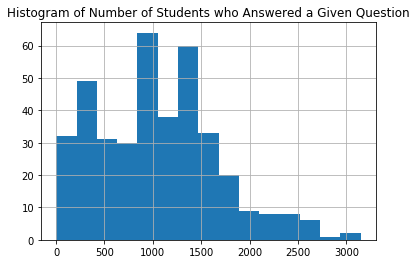

In [43]:
question_user_count = data.groupby(['question_id']).size() #getting the counts of students who answered each question
question_user_count.hist(bins=15)
plt.title("Histogram of Number of Students who Answered a Given Question")
plt.show()

question_less_50 = question_user_count[question_user_count < 50] #getting IDs of questions with less than 50 students

Before I get rid of students who answer less than 20 questions, I check that those students who answer less questions are not weaker students than those who have answered more. I can roughly check this by comparing the distribution of proportion of questions answered correctly for the 2 different populations. From the histograms below, the histograms seem to have the same shape so we can proceed with filtering out students who answer less than 20 questions.

In [44]:
user_question_count = data.groupby(['user_id']).size()
user_more_20 = user_question_count[user_question_count >= 20] #getting IDs of students who answered 20 questions or more

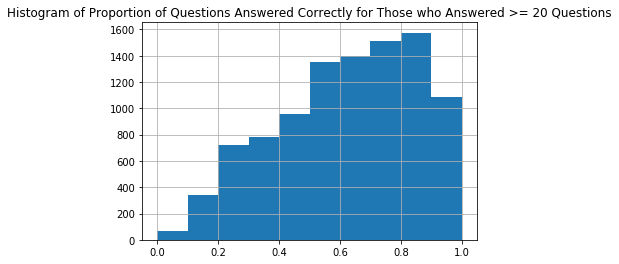

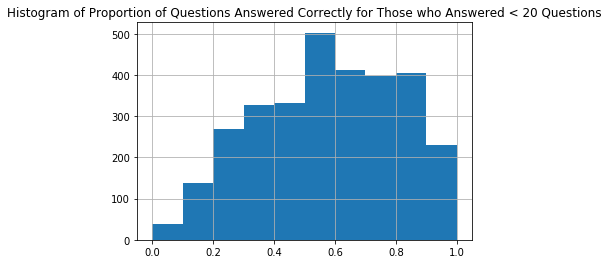

In [45]:
pop1 = data.loc[data['user_id'].isin(user_more_20.index)] #filter out those who answered less than 20 questions
pop1mean = pop1.groupby(['user_id']).mean()
pop1mean['correct'].hist()
plt.title("Histogram of Proportion of Questions Answered Correctly for Those who Answered >= 20 Questions")
plt.show()

pop2 = data.loc[~data['user_id'].isin(user_more_20.index)]#filter out those who answered 20 questions or more
pop2mean = pop2.groupby(['user_id']).mean()
pop2mean['correct'].hist()
plt.title("Histogram of Proportion of Questions Answered Correctly for Those who Answered < 20 Questions")
plt.show()

In [48]:
#filtering out questions and users that don't have enough observations
data = data.loc[data['user_id'].isin(user_more_20.index)]
data = data.loc[~data['question_id'].isin(question_less_50)]

After filtering out some questions and students, we are left with 378 questions and 9785 students for a total of 357,352 observations. Next, I map the IDs of the questions and IDs of the students to the sets $\{1, 2, \dots, 378\}$ and $\{1, 2, \dots, 9785}\$ respectively as pystan requires these identifiers to be consecutive positive integers starting from 1. Then we can pass the data into the model in pystan.

In [49]:
# mapping the question IDs to 1,2,...
uniq_q = np.unique(data['question_id'])
new_id1 = np.arange(1,len(uniq_q)+1)
qdict = dict(zip(uniq_q, new_id1))
data['q_id'] = data.apply(lambda row: qdict[row.question_id], axis=1)

# mapping the student IDs to 1,2,...
uniq_u = np.unique(data['user_id'])
new_id2 = np.arange(1,len(uniq_u)+1)
udict = dict(zip(uniq_u, new_id2))
data['u_id'] = data.apply(lambda row: udict[row.user_id], axis=1)

We can now pass the data into pystan to retrieve the posterior draws on the $\alpha_j$s.

In [50]:
# format the data to pass into pystan
lrt_data = {'I': len(uniq_q),
            'J': len(uniq_u),
            'N': len(data.index),
            'ii': data['q_id'],
            'jj': data['u_id'],
            'y': data['correct']}

# fitting the model to the real data
real_fit = sm.sampling(data=lrt_data, iter=1000, chains=4, sample_file='Real_Draws', n_jobs=4, 
                  control={'adapt_delta' : 0.875, 'max_treedepth' : 15})

In [84]:
real_alphas = real_fit.to_dataframe(pars='alpha') 
alpha_est = real_alphas.mean()[9:].as_matrix()

In [72]:
#get the 196 questions with the highest discrimination parameter
alpha_indices = (-alpha_est).argsort()[:196] + 1 

#invert mapping to get original IDs of questions
inv_map = {v: k for k, v in qdict.items()} 
questions_to_keep = np.vectorize(inv_map.get)(alpha_indices)

In [83]:
#find difference between question_bank and questions_to_keep
questions_to_drop = [q for q in question_bank if q not in questions_to_keep] 
print(questions_to_drop)

[13, 27, 28, 37, 45, 53, 54, 56, 64, 65, 66, 92, 102, 114, 130, 155, 159, 165, 166, 167, 192, 194, 206, 223, 230, 255, 276, 302, 310, 337, 349, 367, 369, 436, 438, 445, 461, 470, 471, 504, 527, 537, 575, 595, 597, 602, 607, 631, 639, 647, 648, 662, 691, 696, 704, 705, 708, 710, 753, 760, 809, 813, 815, 817, 818, 914, 999, 1009, 1011, 1014, 1052, 1090, 1112, 1113, 1122, 1135, 1136, 1143, 1146, 1149, 1593, 1600, 1608, 1611, 1612, 1619, 1630, 1632, 1633, 2193, 2208, 2234, 2254, 2354, 2355, 2489, 2497, 2504, 2511, 2514, 2516, 2517, 3917, 5420, 5475, 5480, 5494, 5534, 5553, 5559, 5561, 5566, 5580, 5584, 5591, 5601, 5620, 5916, 11390, 11542, 12109, 12159, 12208, 12674, 12709, 12710, 12716, 12717, 12718, 12719, 12720, 12721, 12729, 12730, 12745, 12749, 12750, 12754, 12755, 12777, 12783, 12793, 12797, 12810, 12812, 12817, 12821, 12929, 12930, 12932, 12949, 13074, 13078, 13080, 13201, 13205, 13215, 13217, 13221, 13222, 13229, 13230, 13235, 13236, 13239, 13241, 13243, 13274, 13276, 13278, 13282,

The IDs of the 195 questions to drop based on the Bayesian 2-parameter IRT model approach are shown above. Since these questions do the worst in terms of discriminating between students who understand the material and those who do not, removing these questions will provide the most meaningful ranking using the test generating algorithm.

# Limitations and Future Work

While the Bayesian 2-parameter IRT model approach was able to infer the student's abilities effectively, it did not infer the difficulty or the discrimination value of the questions nearly as well. Additionally, the IRT model assumes that questions are exchangeable when in actuality they are serially correlated (e.g., a student might experience fatigue as they answer more questions). A violation of this assumption might affect the validity of the results of the analysis. 

If given more time, I could have fit a hierarchical 2-parameter IRT model, placing hyperparameters on the difficulty and discrimination parameters of the questions. A hierarchy over the questions makes sense in this case as we randomly draw the questions that the students will answers (i.e., not every student will answer every question). This would rectify some of the parameter estimates from the simpler model. I tried running a hierarchical model over a simulated dataset, but it took a very long time to run, so I was unsure whether it would be feasible to run it over all 300,000 observations of the original dataset.

## Note on time spent

I spent approximately 10-15 hours on this challenge. Around 3-4 hours was spent researching methods to apply to this data and the rest was spent on playing with the data, trying various ideas, and writing up the report.